In [1]:
import requests
import pandas as pd
import numpy as np
from surveillance_region_map import name_to_region as region_mapping
from variant_to_pango import variant_to_lineage
from download_cases import cases_by_cw
import matplotlib.pyplot as plt

In [2]:
url = 'https://cov-spectrum.ethz.ch/api/resource/sample2'
params = {'country': 'Switzerland',
          'fields': 'date,region,country,division,ageGroup,sex,hospitalized,deceased,pangolinLineage'}
r = requests.get(url, params)
r.status_code

200

In [3]:
df = pd.read_json(r.content)
# Unroll the count compression, one row per sample
df = df.loc[df.index.repeat(df['count'])]  # %%
df = df.set_index('date')
df = df.assign(reg=lambda x: x.division.map(
    region_mapping).fillna(0).astype('int64'))

In [4]:


def lineage_to_variant(lineage: str) -> str:
    for val, keys in variant_to_lineage.items():
        if lineage in keys:
            return val
    return 'Others'


df = df.assign(variant=lambda x: x.pangolinLineage.map(lineage_to_variant))

In [5]:
variants_by_reg = pd.pivot_table(df, values='region', columns='variant', aggfunc='count', fill_value=0, index=[
    'reg', pd.Grouper(level='date', freq='W-MON', label='left', closed='left')])
variants_by_reg

variant         Alpha  Beta  Delta  Gamma  Others
reg date                                         
0   2020-03-02      0     0      0      0      16
    2020-03-09      0     0      0      0      83
    2020-03-16      0     0      0      0     200
    2020-03-23      0     0      0      0      56
    2020-03-30      0     0      0      0      62
...               ...   ...    ...    ...     ...
6   2021-05-10     82     0      0      1       6
    2021-05-17     74     0      0      2      11
    2021-05-24     30     2      0      1       9
    2021-05-31     24     0      2      0      14
    2021-06-07      4     0      1      0       3

[425 rows x 5 columns]

In [6]:
# Sequences by week by region
seq_by_reg = pd.concat([variants_by_reg.loc[1:], pd.concat(
    {0: variants_by_reg.sum(level=1)}, names=['reg'])]).sort_index()
seq_by_reg = seq_by_reg.assign(Sequences=lambda x: x.sum(axis=1))

In [7]:
seq_and_cases = seq_by_reg.join(cases_by_cw(), how='outer').rename(
    columns={'region': 'sequences', 'entries': 'cases'}).fillna(0).astype('int64')

In [8]:
seq_and_cases.to_csv('cases_seq_by_cw_region.csv')
seq_and_cases.xs(1, level='reg')[-10:]

,Alpha,Beta,Delta,Gamma,Others,Sequences,Cases
date,,,,,,,
2021-04-19,414,2,3,2,48,469,3709
2021-04-26,396,1,8,2,39,446,3100
2021-05-03,370,1,4,1,40,416,2755
2021-05-10,375,1,6,0,23,405,2058
2021-05-17,325,0,5,3,36,369,1749
2021-05-24,264,1,21,1,17,304,1324
2021-05-31,80,0,9,0,4,93,837
2021-06-07,22,0,14,0,4,40,492
2021-06-14,0,0,0,0,0,0,254


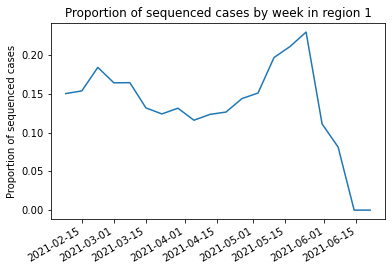

In [9]:
gen = seq_and_cases.loc[1].iloc[-20:]
fig, ax = plt.subplots()
ax.plot(gen.index, gen.Sequences/gen.Cases)
ax.set_title("Proportion of sequenced cases by week in region 1")
ax.set_ylabel("Proportion of sequenced cases")
fig.autofmt_xdate()

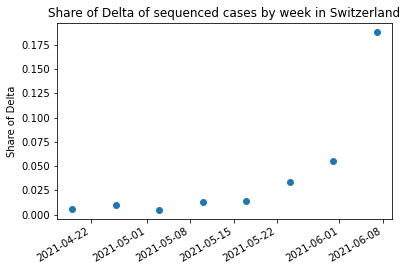

In [10]:
gen = seq_and_cases.loc[0].iloc[-10:]
fig, ax = plt.subplots()
ax.scatter(gen.index, gen.Delta/gen.Sequences)
ax.set_title("Share of Delta of sequenced cases by week in Switzerland")
ax.set_ylabel("Share of Delta")
fig.autofmt_xdate()

Text(0, 0.5, '# of sequences')

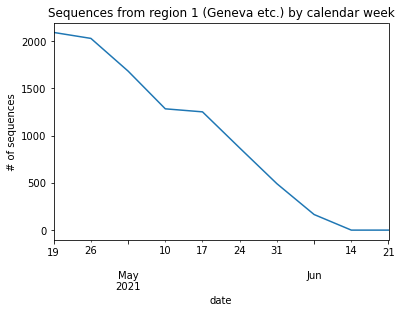

In [11]:
fig = gen.Sequences.plot()
fig.set_title("Sequences from region 1 (Geneva etc.) by calendar week")
fig.set_ylabel("# of sequences")
